In [1]:
import copy
import json
import os
from pathlib import Path
import sys
import warnings
import flash_attn

import torch
from anndata import AnnData
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import pandas as pd
import tqdm
import gseapy as gp

from torchtext.vocab import Vocab
from torchtext._torchtext import (
    Vocab as VocabPybind,
)

sys.path.insert(0, "../")
import scgpt as scg
from scgpt.tasks import GeneEmbedding
from scgpt.tokenizer.gene_tokenizer import GeneVocab
from scgpt.model import TransformerModel
from scgpt.preprocess import Preprocessor
from scgpt.utils import set_seed
from scipy.sparse import csr_matrix, csc_matrix


os.environ["KMP_WARNINGS"] = "off"
warnings.filterwarnings('ignore')

/samurlab1/Joshua/joshMiniforge3/envs/scgpt_aries2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/samurlab1/Joshua/scGPT/scgpt/model/model.py:21: UserWarning: flash_attn is not installed
  warnings.warn("flash_attn is not installed")
/samurlab1/Joshua/scGPT/scgpt/model/multiomic_model.py:19: UserWarning: flash_attn is not installed
  warnings.warn("flash_attn is not installed")


In [2]:
sc.settings.verbosity = 3
sc.logging.print_versions()
sc.set_figure_params(facecolor = "white", dpi=80)

-----
anndata     0.10.9
scanpy      1.9.8
-----
PIL                 10.4.0
aiohappyeyeballs    2.4.0
aiohttp             3.10.5
aiosignal           1.2.0
asttokens           NA
async_timeout       4.0.2
attr                21.4.0
brotli              1.1.0
certifi             2024.08.30
cffi                1.17.1
charset_normalizer  3.3.2
comm                0.2.2
cycler              0.12.1
cython_runtime      NA
datasets            2.21.0
dateutil            2.9.0.post0
debugpy             1.8.5
decorator           5.1.1
defusedxml          0.7.1
dill                0.3.8
einops              0.8.0
exceptiongroup      1.2.2
executing           2.1.0
filelock            3.16.1
flash_attn          NA
frozenlist          1.3.0
fsspec              2024.6.1
google              NA
gseapy              1.1.3
h5py                3.11.0
huggingface_hub     0.25.0
idna                3.10
igraph              0.11.6
ipykernel           6.29.5
jedi                0.19.1
joblib              1.4.2
ki

In [3]:
set_seed(42)
pad_token = "<pad>"
special_tokens = [pad_token, "<cls>", "<eoc>"]
n_hvg = 1200
n_bins = 51
mask_value = -1
pad_value = -2
n_input_bins = n_bins

In [4]:
model_dir = Path("//samurlab1/Joshua/scGPT_models/")
model_config_file = model_dir / "args.json"
model_file = model_dir / "best_model.pt"
vocab_file = model_dir / "vocab.json"

vocab = GeneVocab.from_file(vocab_file)
for s in special_tokens:
    if s not in vocab: 
        vocab.append_token(s)

with open(model_config_file, "r") as f:
    model_configs = json.load(f)
print(
    f"Resume model from {model_file}, the model args will override the "
    f"config {model_config_file}."
)
embsize = model_configs["embsize"]
nhead = model_configs["nheads"]
d_hid = model_configs["d_hid"]
nlayers = model_configs["nlayers"]
n_layers_cls = model_configs["n_layers_cls"]

gene2idx = vocab.get_stoi()

Resume model from //samurlab1/Joshua/scGPT_models/best_model.pt, the model args will override the config //samurlab1/Joshua/scGPT_models/args.json.


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ntokens = len(vocab)  # size of vocabulary
model = TransformerModel(
    ntokens,
    embsize,
    nhead,
    d_hid,
    nlayers,
    vocab=vocab,
    pad_value=pad_value,
    n_input_bins=n_input_bins,
)

try:
    model.load_state_dict(torch.load(model_file))
    print(f"Loading all model params from {model_file}")
except:
    # only load params that are in the model and match the size
    model_dict = model.state_dict()
    pretrained_dict = torch.load(model_file)
    pretrained_dict = {
        k: v
        for k, v in pretrained_dict.items()
        if k in model_dict and v.shape == model_dict[k].shape
    }
    for k, v in pretrained_dict.items():
        print(f"Loading params {k} with shape {v.shape}")
        model_dict.update(pretrained_dict)
        model.load_state_dict(model_dict)

model.to(device)

Loading params encoder.embedding.weight with shape torch.Size([60697, 512])
Loading params encoder.enc_norm.weight with shape torch.Size([512])
Loading params encoder.enc_norm.bias with shape torch.Size([512])
Loading params value_encoder.linear1.weight with shape torch.Size([512, 1])
Loading params value_encoder.linear1.bias with shape torch.Size([512])
Loading params value_encoder.linear2.weight with shape torch.Size([512, 512])
Loading params value_encoder.linear2.bias with shape torch.Size([512])
Loading params value_encoder.norm.weight with shape torch.Size([512])
Loading params value_encoder.norm.bias with shape torch.Size([512])
Loading params transformer_encoder.layers.0.self_attn.out_proj.weight with shape torch.Size([512, 512])
Loading params transformer_encoder.layers.0.self_attn.out_proj.bias with shape torch.Size([512])
Loading params transformer_encoder.layers.0.linear1.weight with shape torch.Size([512, 512])
Loading params transformer_encoder.layers.0.linear1.bias with 

TransformerModel(
  (encoder): GeneEncoder(
    (embedding): Embedding(60697, 512, padding_idx=60694)
    (enc_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (value_encoder): ContinuousValueEncoder(
    (dropout): Dropout(p=0.5, inplace=False)
    (linear1): Linear(in_features=1, out_features=512, bias=True)
    (activation): ReLU()
    (linear2): Linear(in_features=512, out_features=512, bias=True)
    (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=512, bias=True)
        (dropout): Dropout(p=0.5, inplace=False)
        (linear2): Linear(in_features=512, out_features=512, bias=True)
        (norm1): LayerNorm((512,), eps=1e-05, elementwis

In [7]:
import scanpy as sc
import anndata as ad
import numpy as np
import warnings as wrn

wrn.filterwarnings("ignore")

import pooch


In [8]:
adata = sc.read('/samurlab1/Joshua/h5ad/neuts.h5ad')
adata.obs['active.ident']

Myeloid_BM_234868_AAACCCAAGAGTCTTC-1       S100A8+LTF+imtr_neut
Myeloid_BM_234868_AAACCCAGTGAGGCAT-1    S100A8/9+MMP9+imtr_neut
Myeloid_BM_234868_AAACCCAGTTCTCCTG-1       Malat1+NCF1+mat_neut
Myeloid_BM_234868_AAACCCATCCCATTCG-1       Malat1+NCF1+mat_neut
Myeloid_BM_234868_AAACGCTAGGAGCAAA-1    S100A8/9+MMP9+imtr_neut
                                                 ...           
Myeloid_OL_551452_TTTGGTTCATGGCGCT-1      FCGR3B+CXCR2+mat_neut
Myeloid_OL_551452_TTTGGTTTCATATGGC-1      FCGR3B+CXCR2+mat_neut
Myeloid_OL_551452_TTTGTTGAGACATATG-1      FCGR3B+CXCR2+mat_neut
Myeloid_OL_551452_TTTGTTGAGCTGCGAA-1      FCGR3B+CXCR2+mat_neut
Myeloid_OL_551452_TTTGTTGTCTAGTCAG-1      FCGR3B+CXCR2+mat_neut
Name: active.ident, Length: 84616, dtype: category
Categories (9, object): ['FCGR3B+CXCR2+mat_neut', 'S100A8+CD14+MAC', 'S100A8/9+MMP9+imtr_neut', 'LTF+CAMP+imtr_neut', ..., 'CXCL8+VEGFA+mat_neut', 'Malat1+NCF1+mat_neut', 'Mki67+DEFA3+pre-neut', 'HLA-DR+CD16+mac']

filtered out 4977 genes that are detected in less than 5 cells


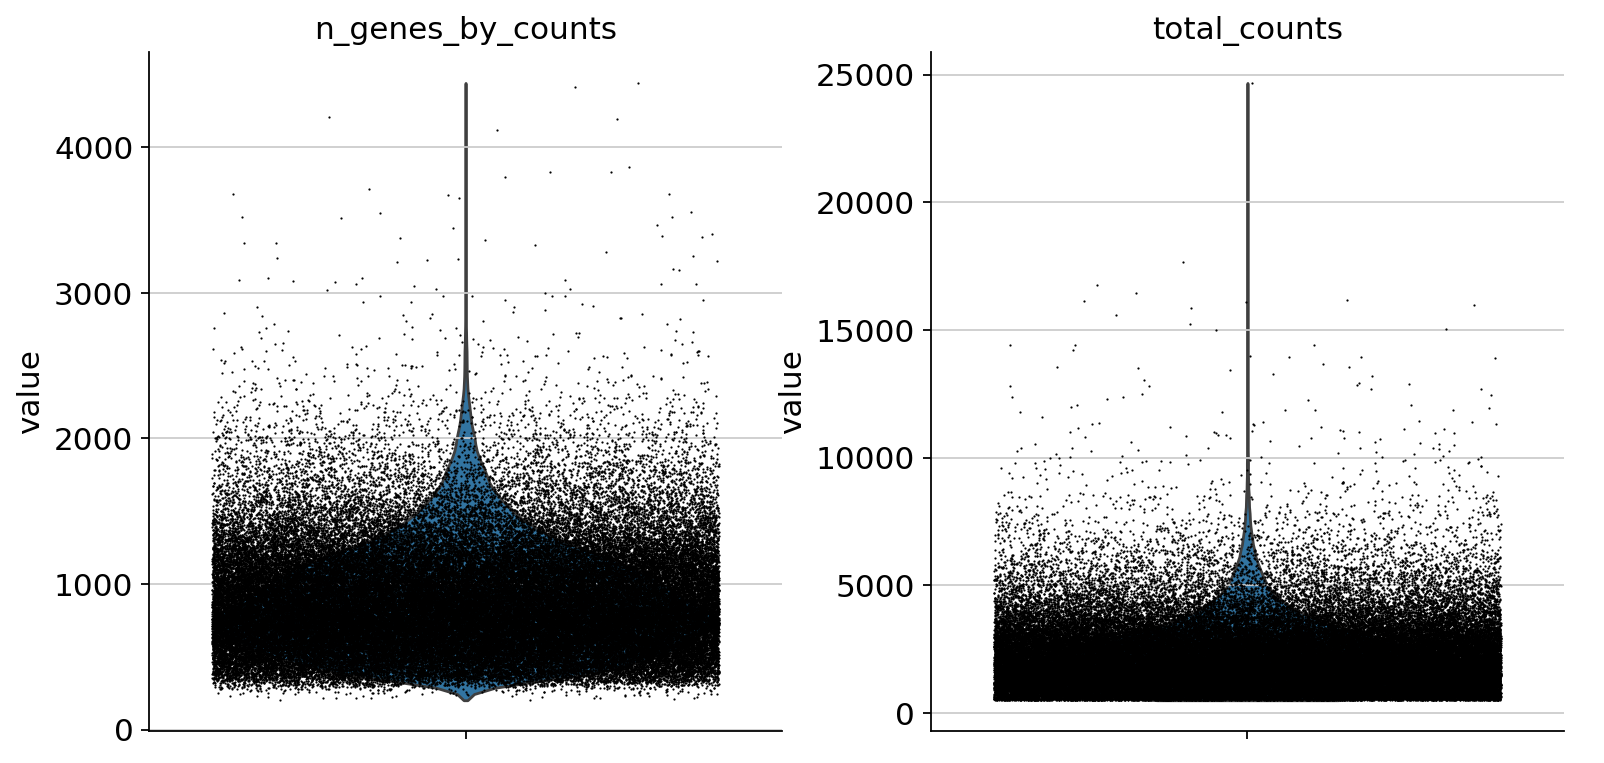

In [9]:
adata.var_names_make_unique()
adata.var

sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=5)

#mitrochondrial genes removal "MT-" for human, "Mt- for mouse"
adata.var["MT"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["MT"], percent_top=None, log1p=False, inplace=True
)
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS","RPL"))

sc.pl.violin(
    adata,
    ["n_genes_by_counts","total_counts"],
    jitter = 0.4,
    multi_panel = True
)



In [10]:
adata.var_names
adata.var_names_make_unique()
adata.var

,name,n_cells,MT,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,ribo
AL627309.1,AL627309.1,376,False,376,0.004562,99.555640,386.0,False
AL669831.5,AL669831.5,716,False,716,0.008793,99.153824,744.0,False
LINC00115,LINC00115,300,False,300,0.003735,99.645457,316.0,False
FAM41C,FAM41C,890,False,890,0.010920,98.948189,924.0,False
AL645608.3,AL645608.3,26,False,26,0.000307,99.969273,26.0,False
...,...,...,...,...,...,...,...,...
AL121820.1,AL121820.1,6,False,6,0.000071,99.992909,6.0,False
AC021483.1,AC021483.1,9,False,9,0.000106,99.989364,9.0,False
RHCG,RHCG,8,False,8,0.000130,99.990546,11.0,False
IGLON5,IGLON5,7,False,7,0.000118,99.991727,10.0,False


In [11]:
from scipy.sparse import csr_matrix, csc_matrix

# Check if adata.X is sparse (either csr_matrix or csc_matrix) and convert to dense
if isinstance(adata.X, (csr_matrix, csc_matrix)):
    adata.X = adata.X.toarray()  # Convert sparse matrix to dense array

sc.pl.highest_expr_genes(adata, n_top=20)

normalizing counts per cell


In [7]:
# Specify data path; here we load the Human Neutrophil dataset Rivera et.al 2025
data_dir = Path("/samurlab1/Joshua/h5ad")
#I have some data I already imported above so I will comment out above code
adata = sc.read(
    str(data_dir / "neuts.h5ad"), cache=True
)  # 33506 × 12303
ori_batch_col = "batch"
adata.obs["celltype"] = adata.obs["active.ident"].astype(str)
data_is_raw = False
adata.var_names_make_unique()
adata.var

,name
AL627309.1,AL627309.1
AL669831.5,AL669831.5
LINC00115,LINC00115
FAM41C,FAM41C
AL645608.3,AL645608.3
...,...
GOLGA8J,GOLGA8J
AC066612.2,AC066612.2
AC087190.2,AC087190.2
AC018552.2,AC018552.2


In [9]:
# Preprocess the data following the scGPT data pre-processing pipeline
preprocessor = Preprocessor(
    use_key="X",  # the key in adata.layers to use as raw data
    filter_gene_by_counts=3,  # step 1
    filter_cell_by_counts=False,  # step 2
    normalize_total=1e4,  # 3. whether to normalize the raw data and to what sum
    result_normed_key="X_normed",  # the key in adata.layers to store the normalized data
    log1p=data_is_raw,  # 4. whether to log1p the normalized data
    result_log1p_key="X_log1p",
    subset_hvg=n_hvg,  # 5. whether to subset the raw data to highly variable genes
    hvg_flavor="seurat_v5" if data_is_raw else "cell_ranger",
    binning=n_bins,  # 6. whether to bin the raw data and to what number of bins
    result_binned_key="X_binned",  # the key in adata.layers to store the binned data
)
print(adata.obs.columns)
#preprocessor(adata, batch_key="batch")

Index(['orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'predicted',
       'predicted.1', 'predicted.2', 'predicted.3', 'predicted.4', 'CD16',
       'MPI', 'AMDI', 'gene_siefert_m2', 'gene_siefert_m1', 'gene_siefert_m0',
       'active.ident', 'tissue', 'patient', 'stage', 'nCount_SCT',
       'nFeature_SCT', 'SCT_snn_res.0.25', 'seurat_clusters', 'ident',
       'celltype'],
      dtype='object')


In [10]:
from scipy.sparse import csr_matrix, csc_matrix

# Check if adata.X is sparse (either csr_matrix or csc_matrix) and convert to dense
if isinstance(adata.X, (csr_matrix, csc_matrix)):
    adata.X = adata.X.toarray()  # Convert sparse matrix to dense array
preprocessor(adata, batch_key="tissue")

scGPT - INFO - Filtering genes by counts ...
filtered out 4135 genes that are detected in less than 3 counts
scGPT - INFO - Normalizing total counts ...
normalizing counts per cell
    finished (0:08:02)
scGPT - INFO - Subsetting highly variable genes ...
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:18:33)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
scGPT - INFO - Binning data ...


In [11]:
# Retrieve the data-independent gene embeddings from scGPT
gene_ids = np.array([id for id in gene2idx.values()])
gene_embeddings = model.encoder(torch.tensor(gene_ids, dtype=torch.long).to(device))
gene_embeddings = gene_embeddings.detach().cpu().numpy()

In [12]:
# Filter on the intersection between the Immune Human HVGs found in step 1.2 and scGPT's 30+K foundation model vocab
gene_embeddings = {gene: gene_embeddings[i] for i, gene in enumerate(gene2idx.keys()) if gene in adata.var.index.tolist()}
print('Retrieved gene embeddings for {} genes.'.format(len(gene_embeddings)))

Retrieved gene embeddings for 917 genes.


In [13]:
# Construct gene embedding network
embed = GeneEmbedding(gene_embeddings)

100%|██████████| 917/917 [00:00<00:00, 125675.62it/s]


In [14]:
# Perform Louvain clustering with desired resolution; here we specify resolution=40
gdata = embed.get_adata(resolution=40)
# Retrieve the gene clusters
metagenes = embed.get_metagenes(gdata)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:14)
running Leiden clustering
    finished: found 289 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:03)


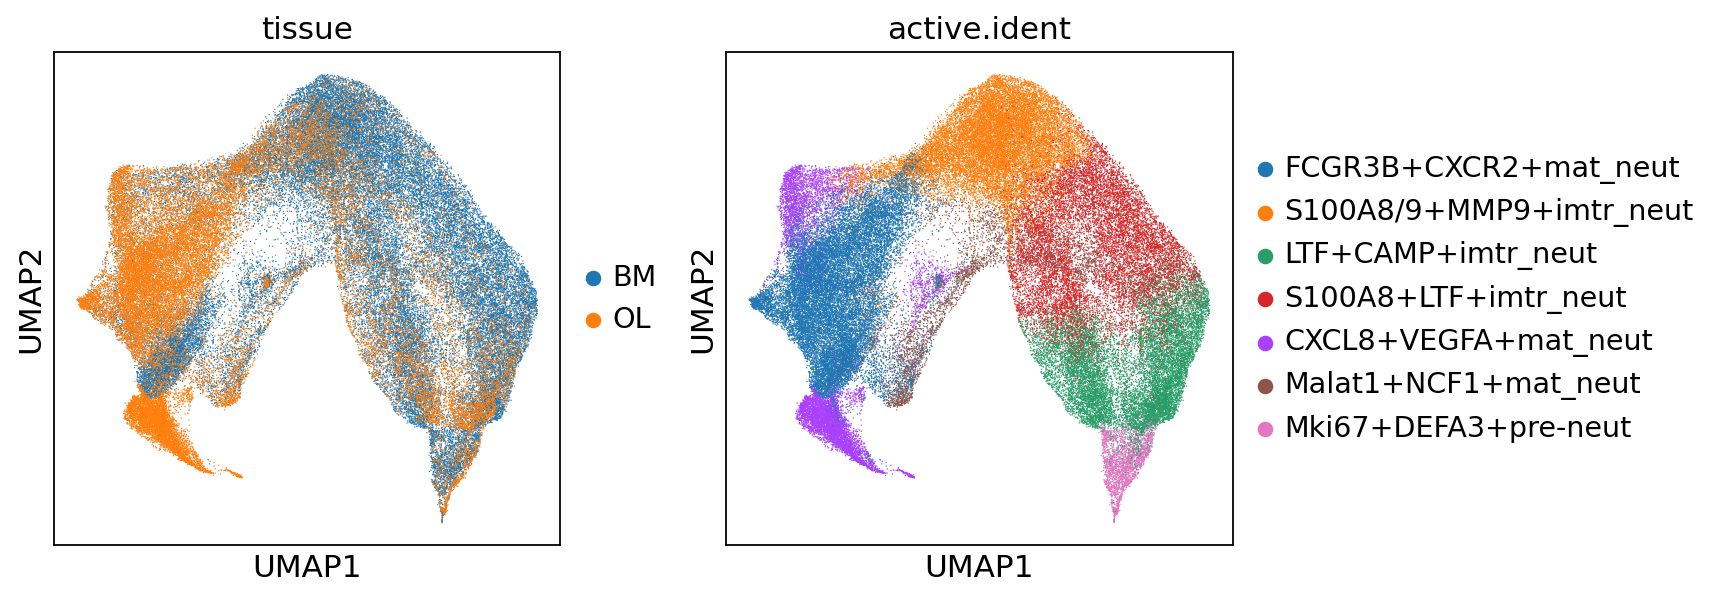

In [15]:
sc.pl.umap(adata, color=['tissue',"active.ident"])
#BM - bonemarrow
#OL - osteolytic lesions from Melanoma

In [16]:
# Obtain the set of gene programs from clusters with #genes >= 5
mgs = dict()
for mg, genes in metagenes.items():
    if len(genes) > 4:
        mgs[mg] = genes

In [17]:
# Here are the gene programs identified
mgs

{'0': ['PRTN3',
  'MS4A3',
  'CTSG',
  'AZU1',
  'MPO',
  'ELANE',
  'RNASE3',
  'CLEC11A',
  'RNASE2'],
 '20': ['PPP2R2B', 'CADM1', 'RORA', 'PCDH9', 'LSAMP'],
 '36': ['PPP1R16B', 'JAM3', 'RAPGEF5', 'EPB41L2', 'GPM6B'],
 '33': ['S100A9', 'LYZ', 'S100A12', 'RETN', 'S100A8'],
 '3': ['MS4A1',
  'IGKV1-39',
  'IGHV2-26',
  'PLD4',
  'FCRLA',
  'CD79B',
  'TCL1A',
  'VPREB3'],
 '9': ['HSPA1B', 'BEX3', 'SOX4', 'HES1', 'TCEAL9', 'STMN1'],
 '12': ['NUSAP1', 'PTTG1', 'CCNB1', 'CDK1', 'TOP2A', 'UBE2C'],
 '26': ['RORB', 'NRG1', 'MAGI3', 'RGS6', 'UNC13C'],
 '22': ['SIGLEC12', 'HSD17B14', 'DHDH', 'ERICH4', 'AQP10'],
 '7': ['CPXM2', 'ANLN', 'ENPP2', 'FGFR2', 'TBC1D12', 'MTUS1'],
 '31': ['MNS1', 'PCNA', 'TYMS', 'FAM111B', 'RRM2'],
 '5': ['MALAT1', 'B2M', 'ACTB', 'FTH1', 'RPLP1', 'FTL', 'TMSB4X'],
 '25': ['MAFB', 'MAF', 'ARL4C', 'GAS6', 'HTRA1'],
 '4': ['LY6E', 'OAS2', 'ISG15', 'MX1', 'IFIT1', 'RSAD2', 'HERC5', 'IFI44L'],
 '8': ['MUCL1', 'OLAH', 'KCNE2', 'LPO', 'DEFB1', 'SLC13A5'],
 '17': ['RNF152', '

computing score '104_SCORE'
    finished: added
    '104_SCORE', score of gene set (adata.obs).
    128 total control genes are used. (0:00:00)
computing score '191_SCORE'
    finished: added
    '191_SCORE', score of gene set (adata.obs).
    95 total control genes are used. (0:00:00)
computing score '61_SCORE'
    finished: added
    '61_SCORE', score of gene set (adata.obs).
    133 total control genes are used. (0:00:00)
computing score '0_SCORE'
    finished: added
    '0_SCORE', score of gene set (adata.obs).
    141 total control genes are used. (0:00:00)
computing score '65_SCORE'
    finished: added
    '65_SCORE', score of gene set (adata.obs).
    183 total control genes are used. (0:00:00)
computing score '20_SCORE'
    finished: added
    '20_SCORE', score of gene set (adata.obs).
    231 total control genes are used. (0:00:00)
computing score '36_SCORE'
    finished: added
    '36_SCORE', score of gene set (adata.obs).
    192 total control genes are used. (0:00:00)
compu

<Figure size 400x1040 with 0 Axes>

<Figure size 320x320 with 0 Axes>

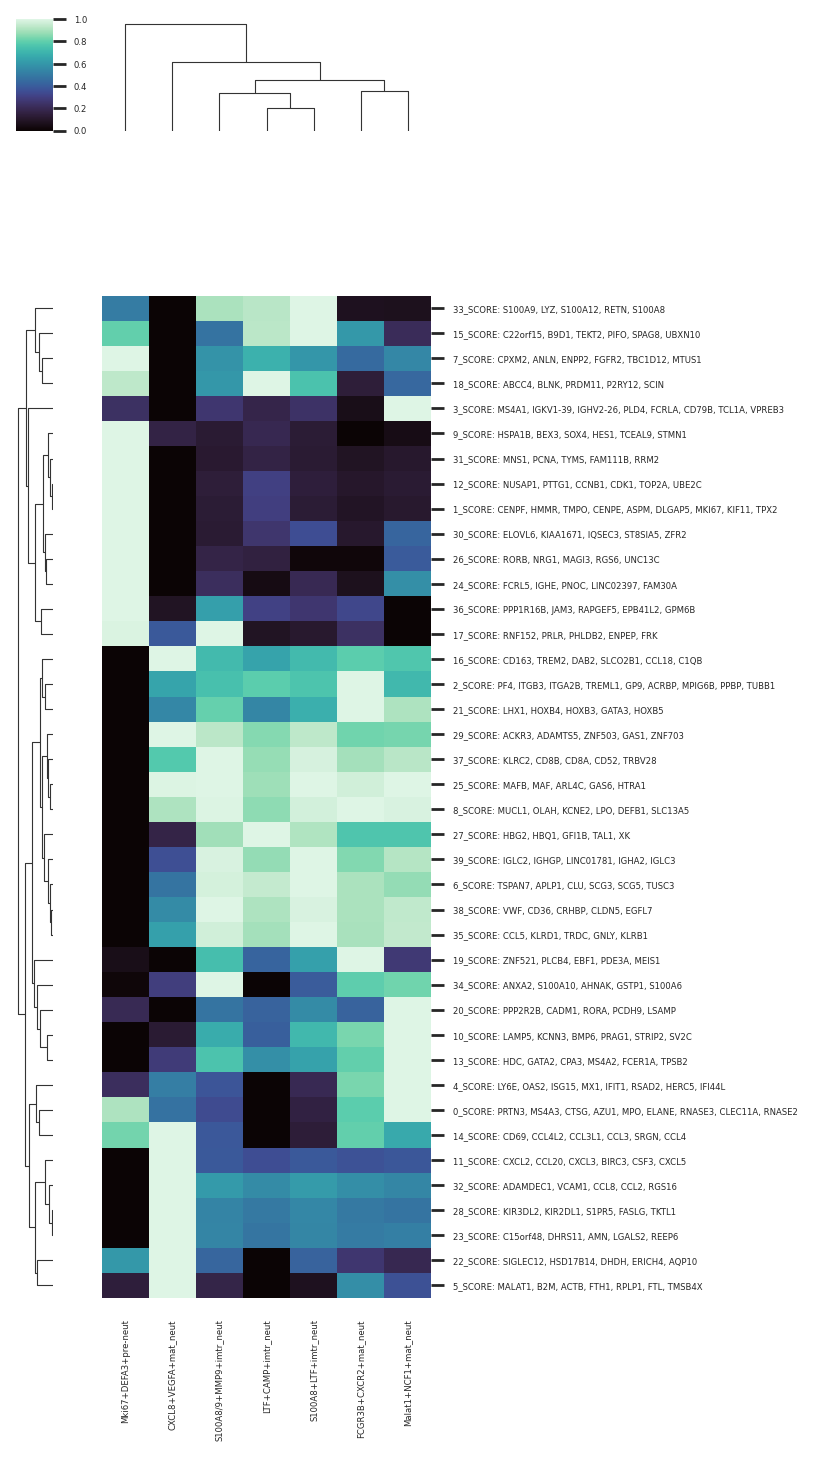

In [18]:
sns.set(font_scale=0.35)
embed.score_metagenes(adata, metagenes)
embed.plot_metagenes_scores(adata, mgs, "celltype")

In [39]:
CD_genes = mgs['3']
print(CD_genes)
df_CD = pd.DataFrame(columns=['Gene', 'Similarity', 'Gene1',"append"])
df_CD

for i in tqdm.tqdm(CD_genes):
    df = embed.compute_similarities(i, CD_genes)
    df['Gene1'] = i
    df_CD = df_CD.append(df)
df_CD_sub = df_CD[df_CD['Similarity']<0.99].sort_values(by='Gene') # Filter out edges from each gene to itself

['MS4A1', 'IGKV1-39', 'IGHV2-26', 'PLD4', 'FCRLA', 'CD79B', 'TCL1A', 'VPREB3']


  0%|          | 0/8 [00:00<?, ?it/s]


TypeError: 'Series' object is not callable

In [34]:
# Creates a graph from the cosine similarity network
input_node_weights = [(row['Gene'], row['Gene1'], round(row['Similarity'], 2)) for i, row in df_CD_sub.iterrows()]
G = nx.Graph()
G.add_weighted_edges_from(input_node_weights)

NameError: name 'df_CD_sub' is not defined

In [ ]:
# Plot the cosine similarity network; strong edges (> select threshold) are highlighted
thresh = 0.4
plt.figure(figsize=(20, 20))
widths = nx.get_edge_attributes(G, 'weight')

elarge = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] > thresh]
esmall = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] <= thresh]

pos = nx.spring_layout(G, k=0.4, iterations=15, seed=3)

width_large = {}
width_small = {}
for i, v in enumerate(list(widths.values())):
    if v > thresh:
        width_large[list(widths.keys())[i]] = v*10
    else:
        width_small[list(widths.keys())[i]] = max(v, 0)*10

nx.draw_networkx_edges(G, pos,
                       edgelist = width_small.keys(),
                       width=list(width_small.values()),
                       edge_color='lightblue',
                       alpha=0.8)
nx.draw_networkx_edges(G, pos,
                       edgelist = width_large.keys(),
                       width = list(width_large.values()),
                       alpha = 0.5,
                       edge_color = "blue",
                      )
# node labels
nx.draw_networkx_labels(G, pos, font_size=25, font_family="sans-serif")
# edge weight labels
d = nx.get_edge_attributes(G, "weight")
edge_labels = {k: d[k] for k in elarge}
nx.draw_networkx_edge_labels(G, pos, edge_labels, font_size=15)

ax = plt.gca()
ax.margins(0.08)
plt.axis("off")
plt.show()

## REACTOME PATHWAY ANALYSIS

In [35]:
# Meta info about the number of terms (tests) in the databases
df_database = pd.DataFrame(
data = [['GO_Biological_Process_2021', 6036],
['GO_Molecular_Function_2021', 1274],
['Reactome_2022', 1818]],
columns = ['dataset', 'term'])

In [36]:
# Select desired database for query; here use Reactome as an example
databases = ['Reactome_2022']
m = df_database[df_database['dataset'].isin(databases)]['term'].sum()
# p-value correction for total number of tests done
p_thresh = 0.05/m

In [41]:
adata.var

,name,n_counts,highly_variable,means,dispersions,dispersions_norm,highly_variable_nbatches,highly_variable_intersection
ISG15,ISG15,16315.0,True,0.205117,7.711268,60.306824,2,True
TNFRSF18,TNFRSF18,25.0,True,0.000320,1.176179,1059.177002,1,False
TNFRSF25,TNFRSF25,14.0,True,0.000166,1.166530,4002.309814,1,False
CAMTA1-DT,CAMTA1-DT,20.0,True,0.000227,1.071227,1180.911133,1,False
ERRFI1,ERRFI1,534.0,True,0.007458,4.381152,6052.470215,2,True
...,...,...,...,...,...,...,...,...
WISP1,WISP1,10.0,True,0.000140,0.599876,1200.591797,1,False
CPXM2,CPXM2,7.0,True,0.000098,0.642777,3430.262207,1,False
SOX5-AS1,SOX5-AS1,4.0,True,0.000056,0.749965,6002.621582,1,False
RHCG,RHCG,11.0,True,0.000154,1.045329,6548.513672,1,False


In [48]:
cxcr8vegf_dge = adata.var["highly_variable_nbatches"]
print(cxcr8vegf_dge)

ISG15        2
TNFRSF18     1
TNFRSF25     1
CAMTA1-DT    1
ERRFI1       2
            ..
WISP1        1
CPXM2        1
SOX5-AS1     1
RHCG         1
IGLON5       1
Name: highly_variable_nbatches, Length: 1200, dtype: int64


In [49]:
# Perform pathway enrichment analysis using the gseapy package in the Reactome database
df = pd.DataFrame()
enr_Reactome = gp.enrichr(gene_list=CD_genes,
                          gene_sets=databases,
                          organism='Human',
                          outdir='test/enr_Reactome',
                          cutoff=0.5)
out = enr_Reactome.results
out = out[out['P-value'] < p_thresh]
df

""


In [19]:
adata.write(filename="/samurlab1/Joshua/h5ad/neuts_scgpt.h5ad")